Initial imports

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from giems_lstm.config import Config
import os
from functools import partial

os.chdir("..")

Data loading

In [2]:
E = xr.open_dataset("output/E_prediction.nc")
F = xr.open_dataset("output/F_prediction.nc")
config = Config("config/E.toml", "analyze")
TVARs = config.TVARs
train_years = config.train.train_years
mask = config.mask
pixel_area = xr.open_dataset("data/clean/PixelArea_area.nc")

Preprocessing

In [3]:
TVARs = {name: dataset.where(mask) for name, dataset in TVARs.items()}
E = E.where(mask)
F = F.where(mask)

E_area = E["fwet"] * pixel_area["area"]
F_area = F["fwet"] * pixel_area["area"]
giems_area = TVARs["giems2"] * pixel_area["area"]

weight = np.nanmax(TVARs["giems2"].values, axis=0)
grace_weighted = TVARs["grace"] * weight
mswep_weighted = TVARs["mswep"] * weight
gleam_weighted = TVARs["gleam"] * weight

C:\Users\FireFighter\AppData\Local\Temp\ipykernel_28744\1334245936.py:9: RuntimeWarning: All-NaN slice encountered
  weight = np.nanmax(TVARs["giems2"].values, axis=0)


## Time Series

Define helpers

In [19]:
def reduce(data_array, sel_lat, sel_lon, time_reso):
    data_sel = data_array.sel(lat=sel_lat, lon=sel_lon)
    return data_sel.mean(dim=["lat", "lon"]).resample(time=time_reso).mean()


def plot_timeseries(datas, labels, title):
    fig, ax = plt.subplots(figsize=(18, 6))
    ax.plot(datas["E"].time, datas["E"], label="Prediction E", color="red")
    ax.plot(datas["F"].time, datas["F"], label="Prediction F", color="orange")
    ax.plot(datas["giems2"].time, datas["giems2"], label="GIEMS2-MC", color="black")
    ax.set_ylabel(labels["giems2"])
    ax.spines[["right", "top"]].set_visible(False)
    ax.legend()

    def draw_compare(data, offset, label, color):
        bx = ax.twinx()
        bx.plot(data.time, data, color=color)
        bx.spines[["left", "top", "bottom"]].set_visible(False)
        bx.spines["right"].set(color=color, position=("axes", offset))
        bx.set_ylabel(label, color=color)
        bx.yaxis.label.set_color(color)
        bx.tick_params(axis="y", colors=color)

    draw_compare(datas["grace"], 1.0, labels["grace"], "green")
    draw_compare(datas["mswep"], 1.05, labels["mswep"], "lightblue")
    draw_compare(datas["gleam"], 1.1, labels["gleam"], "purple")

    for year in train_years:
        ax.axvspan(f"{year}-01-01", f"{year}-12-31", color="gray", alpha=0.2)

    ax.grid(True, axis="x", linestyle="--", alpha=0.5)
    fig.suptitle(title)
    fig.tight_layout()
    return fig

Global Yearly

In [5]:
reduce_GY = partial(
    reduce, sel_lat=slice(-90, 90), sel_lon=slice(-180, 180), time_reso="YS"
)
datas_GY = {
    "E": reduce_GY(E_area),
    "F": reduce_GY(F_area),
    "giems2": reduce_GY(giems_area),
    "grace": reduce_GY(grace_weighted),
    "mswep": reduce_GY(mswep_weighted),
    "gleam": reduce_GY(gleam_weighted),
}

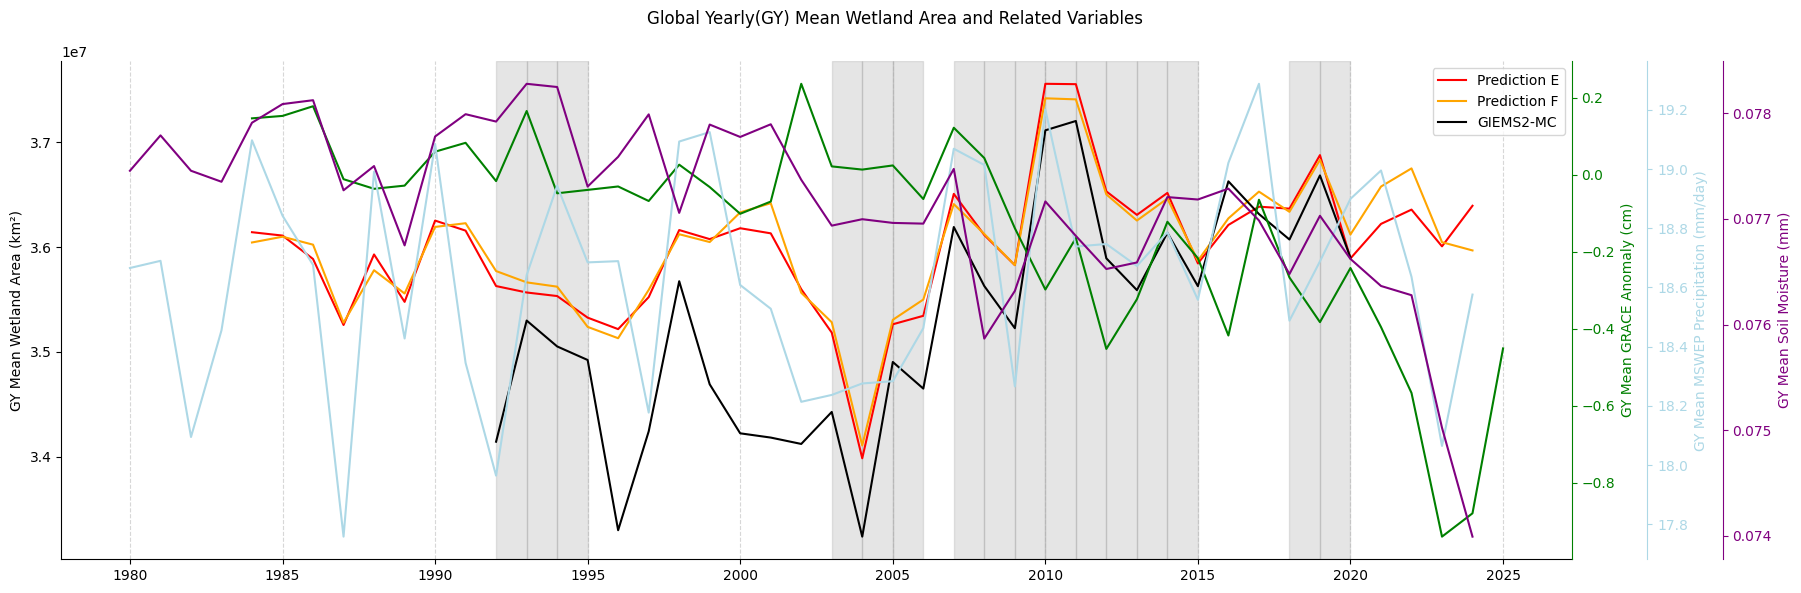

In [21]:
labels_GY = {
    "giems2": "GY Mean Wetland Area (km²)",
    "grace": "GY Mean GRACE Anomaly (cm)",
    "mswep": "GY Mean MSWEP Precipitation (mm/day)",
    "gleam": "GY Mean Soil Moisture (mm)",
}


fig = plot_timeseries(
    datas_GY,
    labels_GY,
    title="Global Yearly(GY) Mean Wetland Area and Related Variables",
)
fig.savefig("figs/GY.svg")

Global Monthly

In [13]:
reduce_GM = partial(
    reduce, sel_lat=slice(-90, 90), sel_lon=slice(-180, 180), time_reso="MS"
)
datas_GM = {
    "E": reduce_GM(E_area),
    "F": reduce_GM(F_area),
    "giems2": reduce_GM(giems_area),
    "grace": reduce_GM(grace_weighted),
    "mswep": reduce_GM(mswep_weighted),
    "gleam": reduce_GM(gleam_weighted),
}

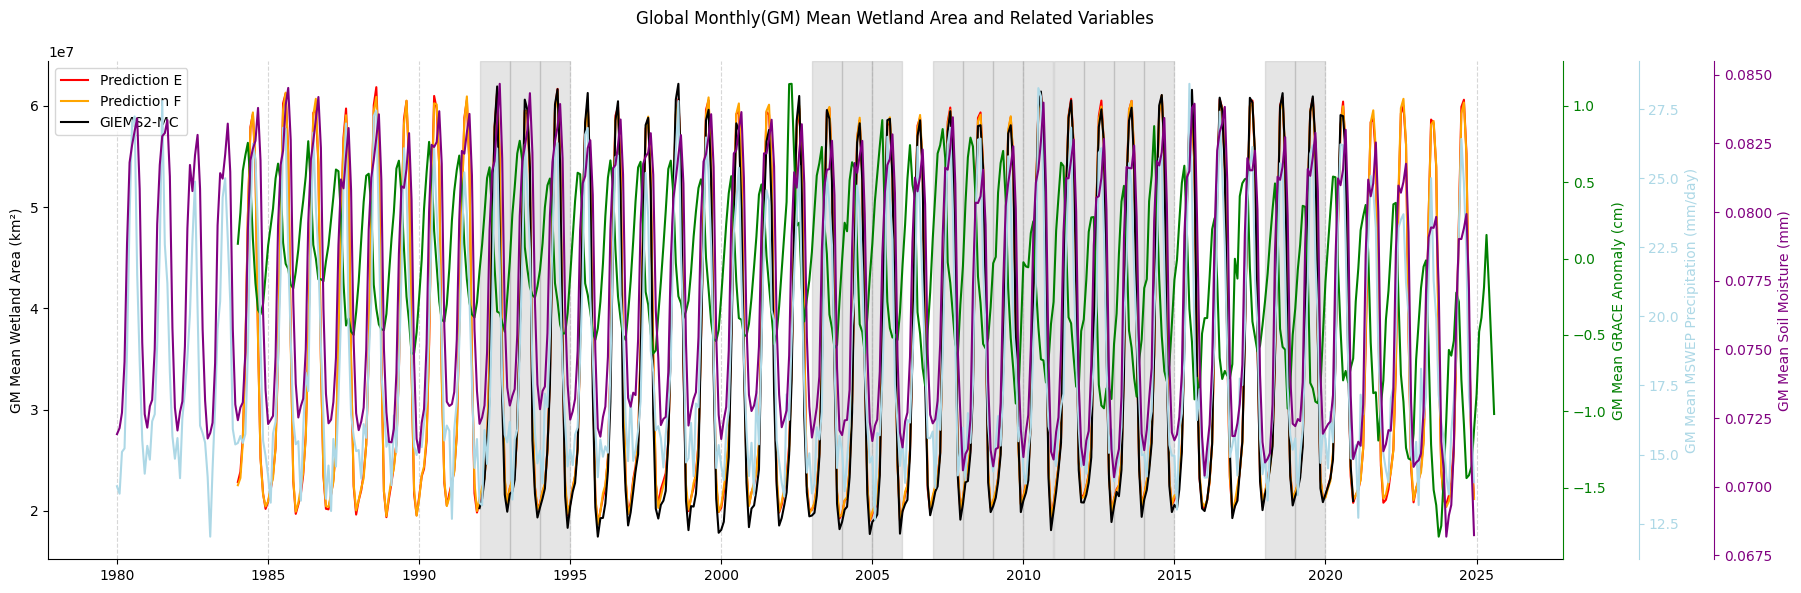

In [22]:
labels_GM = {
    "giems2": "GM Mean Wetland Area (km²)",
    "grace": "GM Mean GRACE Anomaly (cm)",
    "mswep": "GM Mean MSWEP Precipitation (mm/day)",
    "gleam": "GM Mean Soil Moisture (mm)",
}
fig = plot_timeseries(
    datas_GM,
    labels_GM,
    title="Global Monthly(GM) Mean Wetland Area and Related Variables",
)
fig.savefig("figs/GM.svg")

Integrate helpers

In [193]:
def gen_region_reduce(lat_slice, lon_slice, time_reso, short_name, long_name):
    reduce_region = partial(
        reduce, sel_lat=lat_slice, sel_lon=lon_slice, time_reso=time_reso
    )
    datas_region = {
        "E": reduce_region(E_area),
        "F": reduce_region(F_area),
        "giems2": reduce_region(giems_area),
        "grace": reduce_region(grace_weighted),
        "mswep": reduce_region(mswep_weighted),
        "gleam": reduce_region(gleam_weighted),
    }

    labels_region = {
        "giems2": f"{short_name} Mean Wetland Area (km²)",
        "grace": f"{short_name} Mean GRACE Anomaly (cm)",
        "mswep": f"{short_name} Mean MSWEP Precipitation (mm/day)",
        "gleam": f"{short_name} Mean Soil Moisture (mm)",
    }
    fig = plot_timeseries(
        datas_region,
        labels_region,
        title=f"{long_name} ({short_name}) Mean Wetland Area and Related Variables",
    )
    fig.savefig(f"figs/{short_name}.svg")


def plot_awet(datas, short_name, long_name):
    fig, ax = plt.subplots(figsize=(18, 6))
    ax.plot(datas["E"].time, datas["E"], label="Prediction E", color="red")
    ax.plot(datas["F"].time, datas["F"], label="Prediction F", color="orange")
    ax.plot(datas["giems2"].time, datas["giems2"], label="GIEMS2-MC", color="black")
    ax.set_ylabel(f"{short_name} Mean Wetland Area (m²)")
    ax.spines[["right", "top"]].set_visible(False)
    ax.legend()

    for year in train_years:
        ax.axvspan(f"{year}-01-01", f"{year}-12-31", color="gray", alpha=0.2)

    fig.suptitle(f"{long_name} ({short_name}) Mean Wetland Area")
    fig.tight_layout()
    fig.savefig(f"figs/{short_name}_awet.svg")


def gen_region_awet(lat_slice, lon_slice, time_reso, short_name, long_name):
    reduce_region = partial(
        reduce, sel_lat=lat_slice, sel_lon=lon_slice, time_reso=time_reso
    )
    datas_region = {
        "E": reduce_region(E_area),
        "F": reduce_region(F_area),
        "giems2": reduce_region(giems_area),
    }
    plot_awet(datas_region, short_name, long_name)

North Tropical Yearly

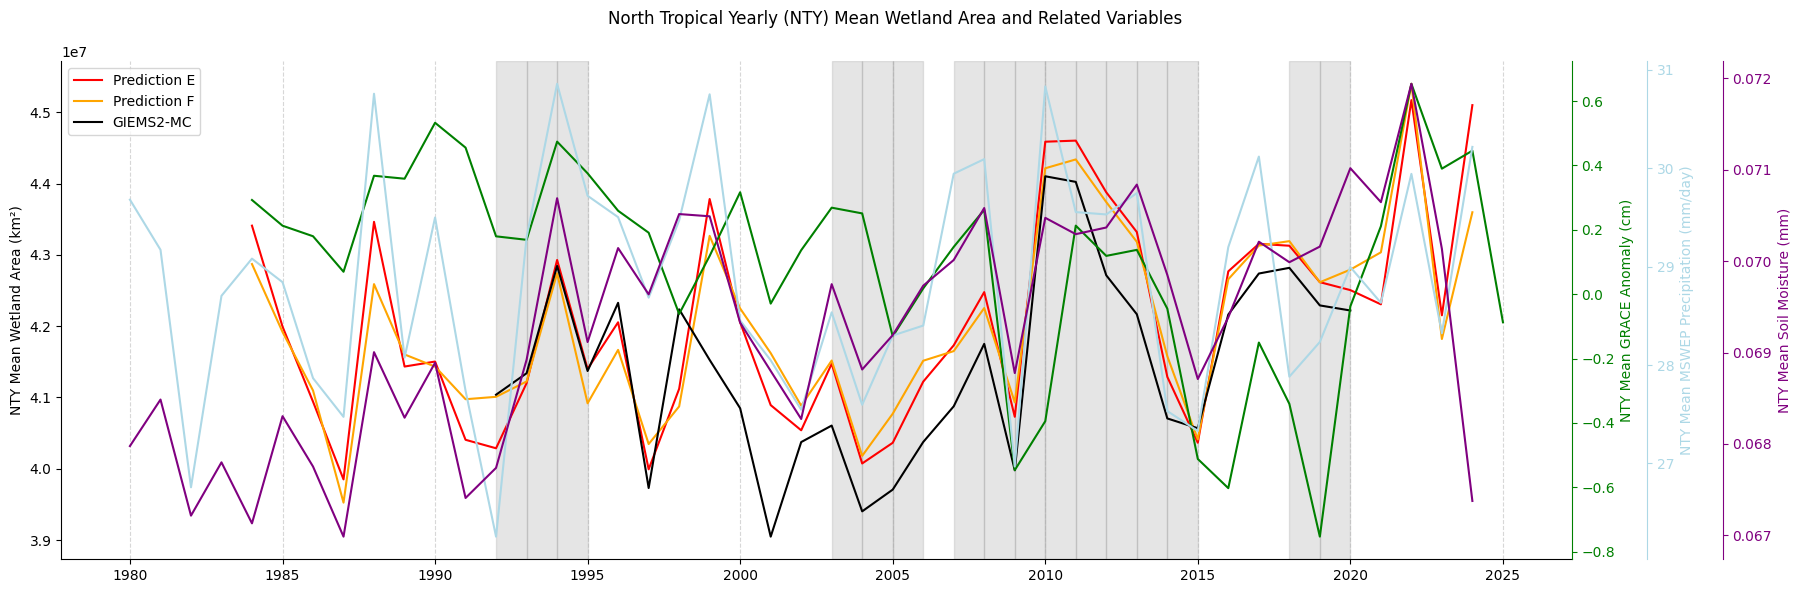

In [41]:
gen_region_reduce(
    lat_slice=slice(0, 30),
    lon_slice=slice(-180, 180),
    time_reso="YS",
    short_name="NTY",
    long_name="North Tropical Yearly",
)

North Tropical Monthly

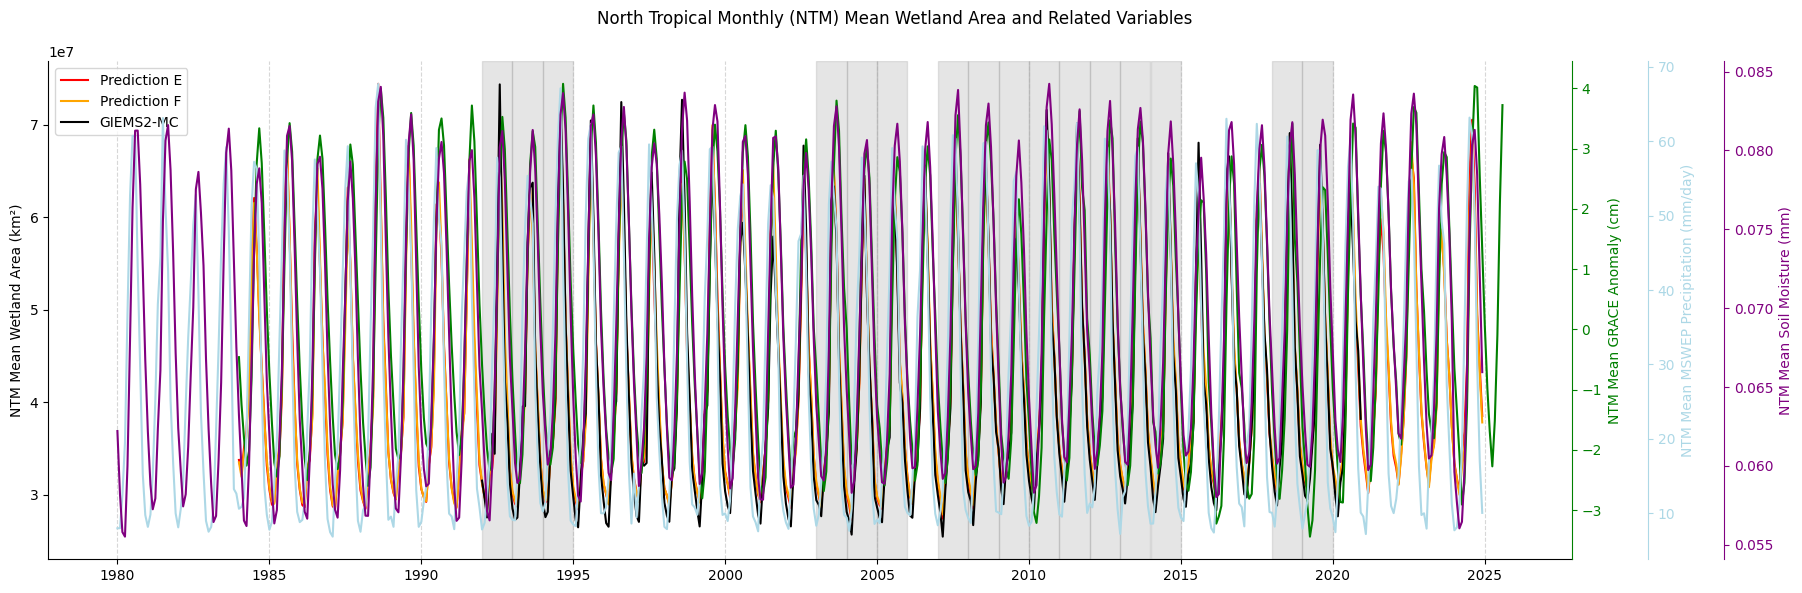

In [42]:
gen_region_reduce(
    lat_slice=slice(0, 30),
    lon_slice=slice(-180, 180),
    time_reso="MS",
    short_name="NTM",
    long_name="North Tropical Monthly",
)

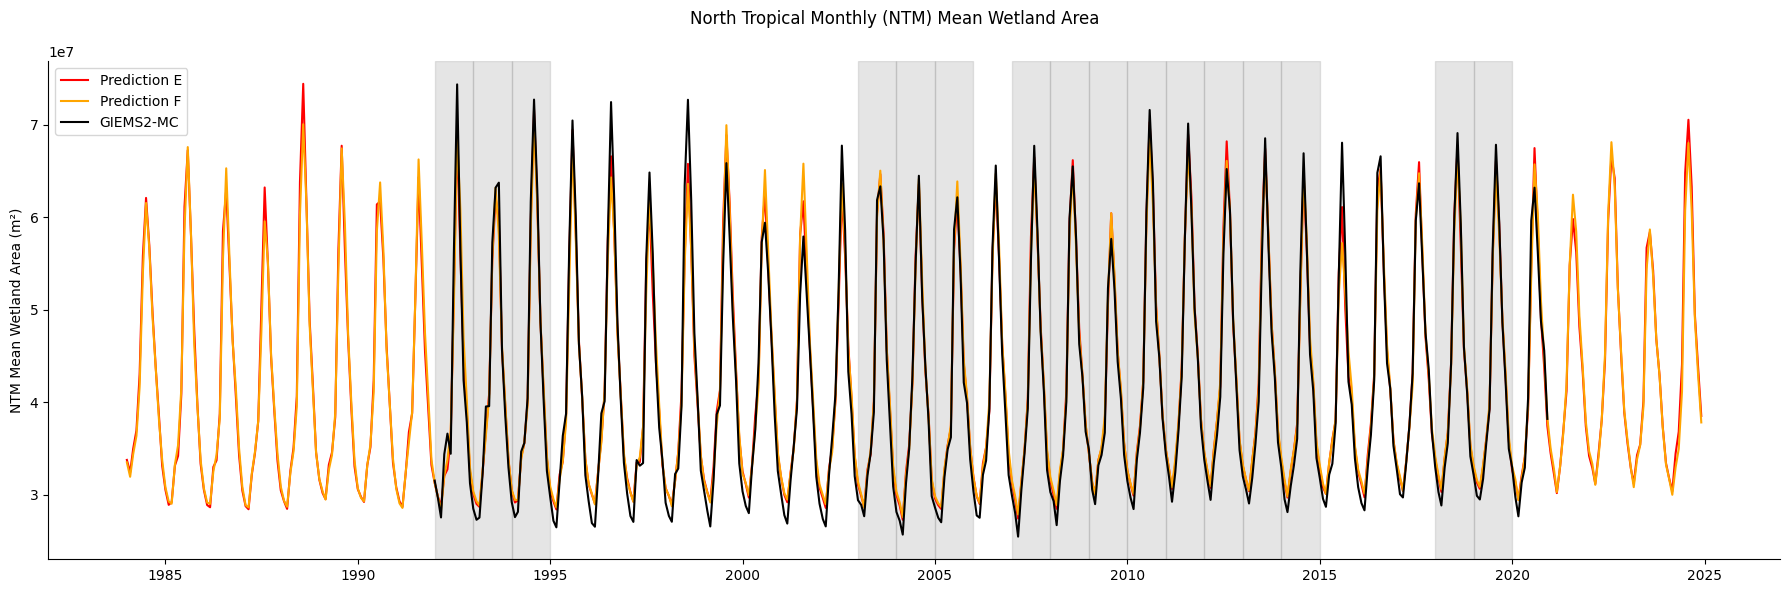

In [194]:
gen_region_awet(
    lat_slice=slice(0, 30),
    lon_slice=slice(-180, 180),
    time_reso="MS",
    short_name="NTM",
    long_name="North Tropical Monthly",
)

South Tropical Yearly

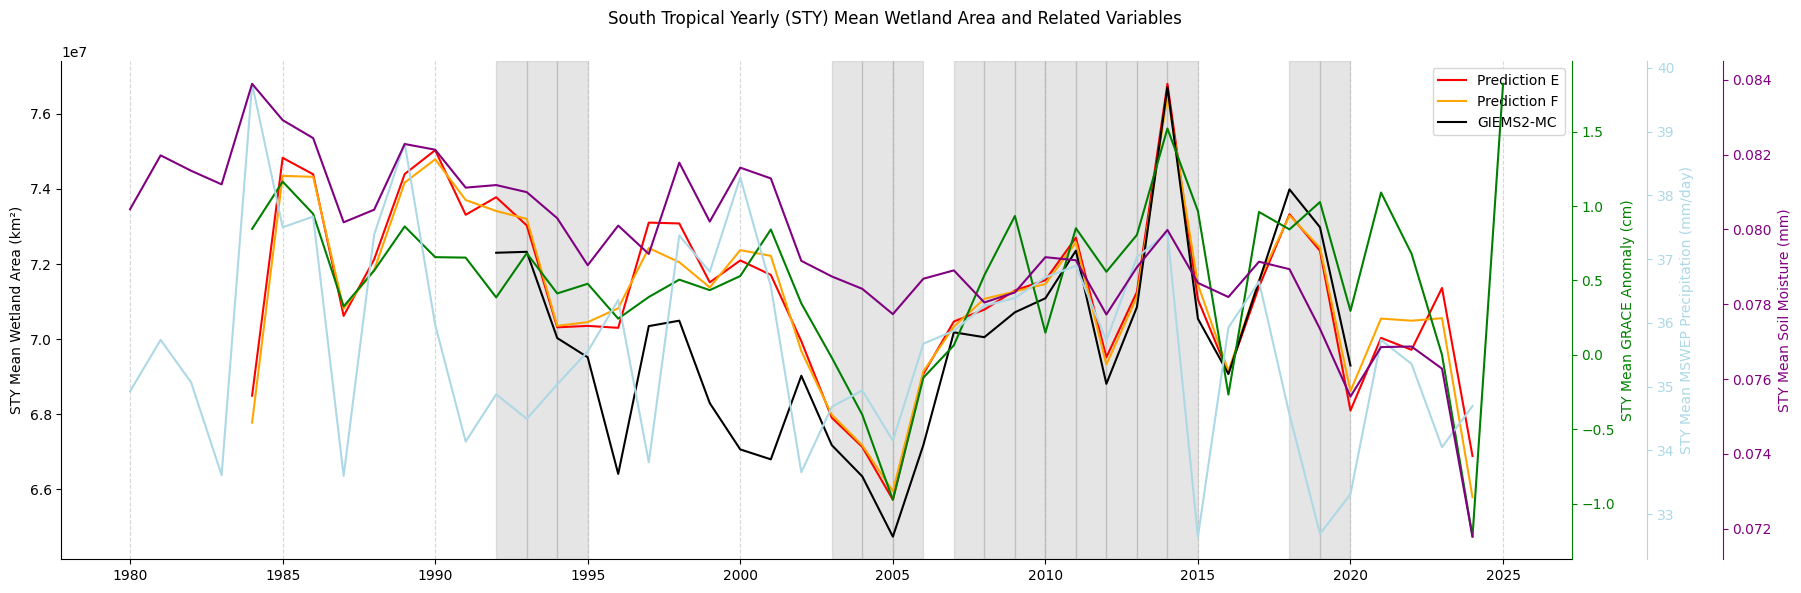

In [43]:
gen_region_reduce(
    lat_slice=slice(-30, 0),
    lon_slice=slice(-180, 180),
    time_reso="YS",
    short_name="STY",
    long_name="South Tropical Yearly",
)

South Tropical Monthly

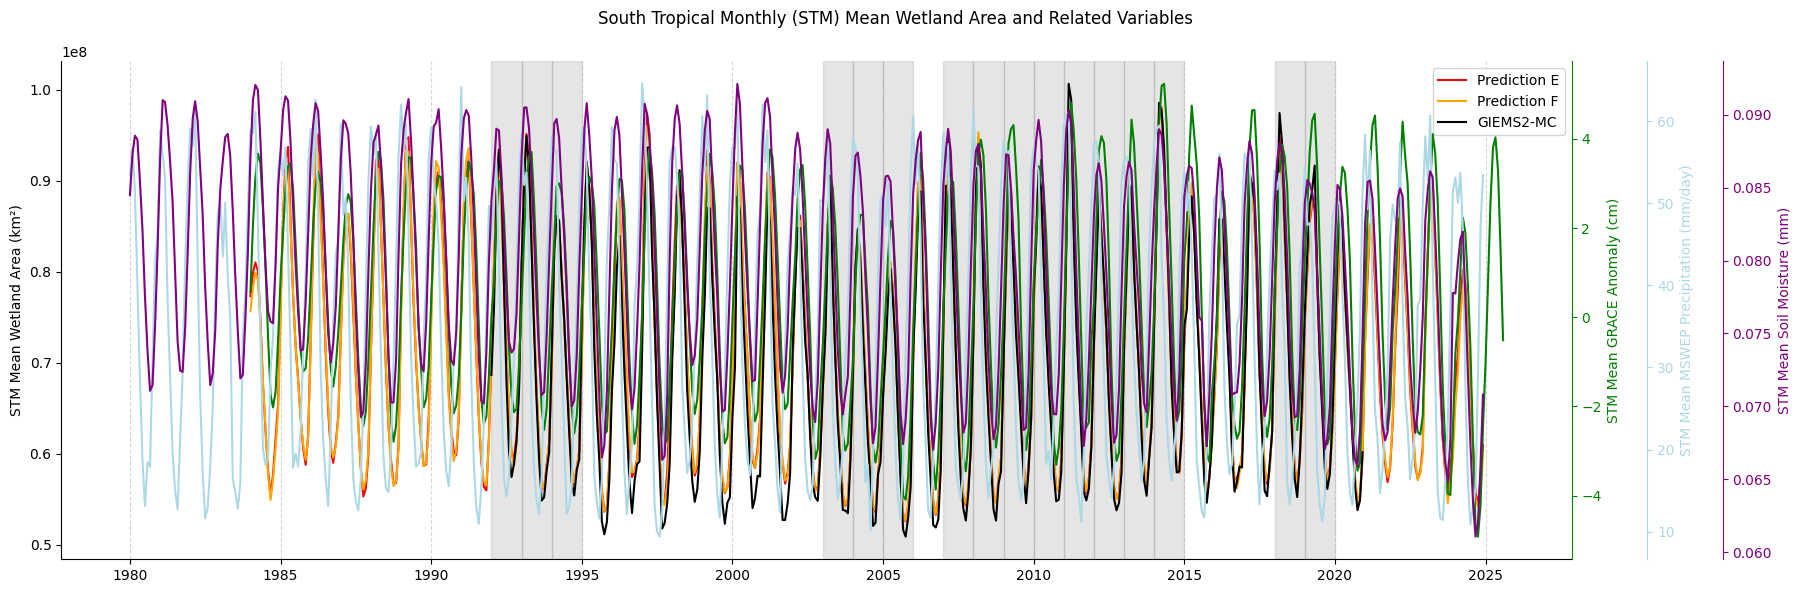

In [44]:
gen_region_reduce(
    lat_slice=slice(-30, 0),
    lon_slice=slice(-180, 180),
    time_reso="MS",
    short_name="STM",
    long_name="South Tropical Monthly",
)

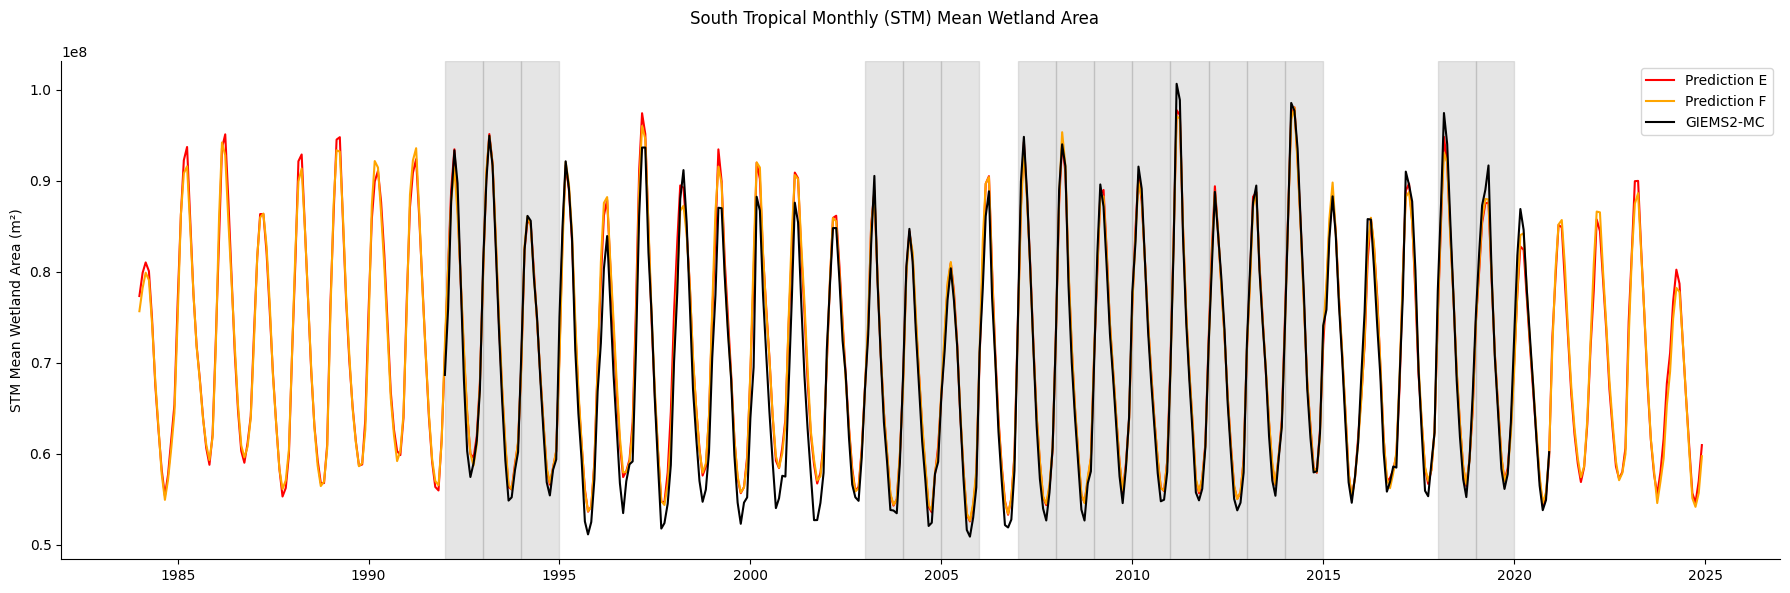

In [195]:
gen_region_awet(
    lat_slice=slice(-30, 0),
    lon_slice=slice(-180, 180),
    time_reso="MS",
    short_name="STM",
    long_name="South Tropical Monthly",
)

Amazon Yearly

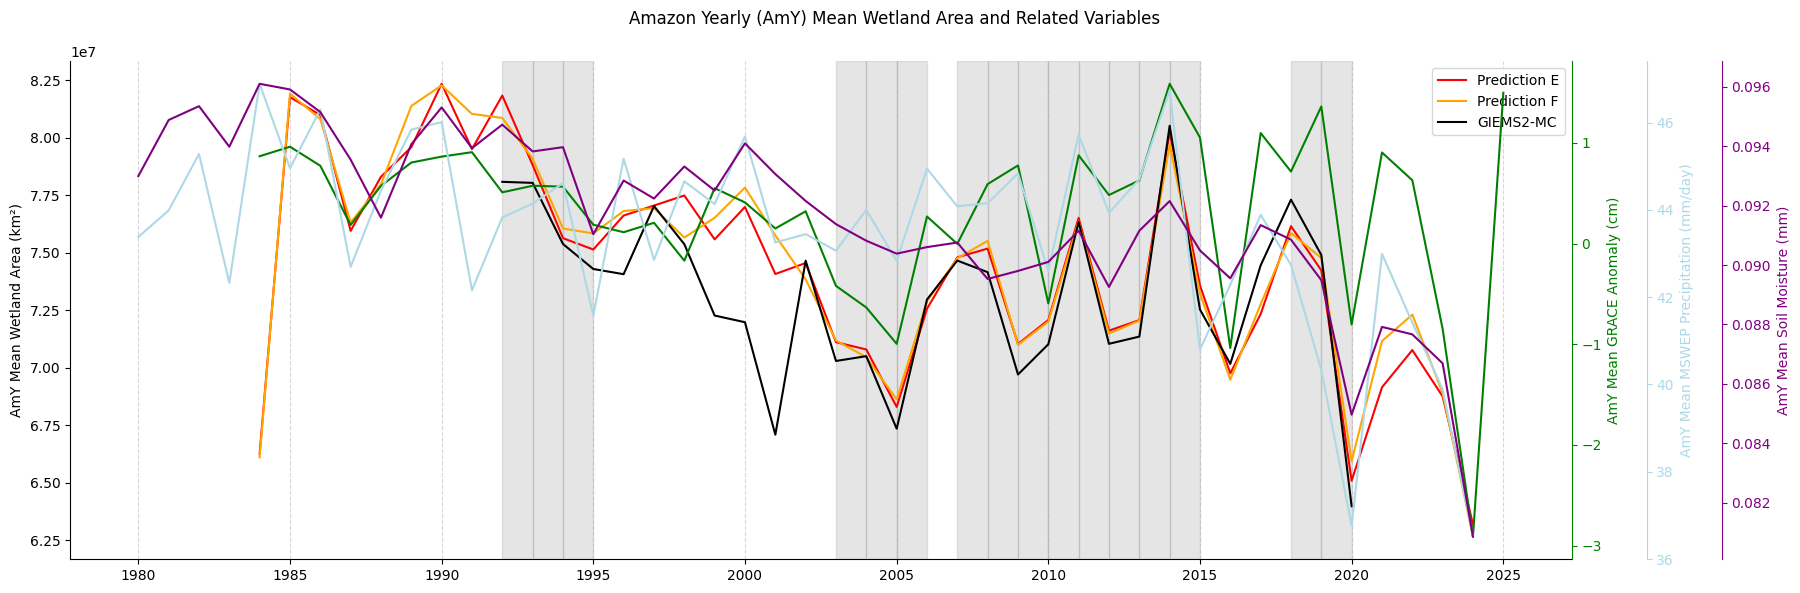

In [45]:
gen_region_reduce(
    lat_slice=slice(-30, 20),
    lon_slice=slice(-80, -40),
    time_reso="YS",
    short_name="AmY",
    long_name="Amazon Yearly",
)

Amazon Monthly

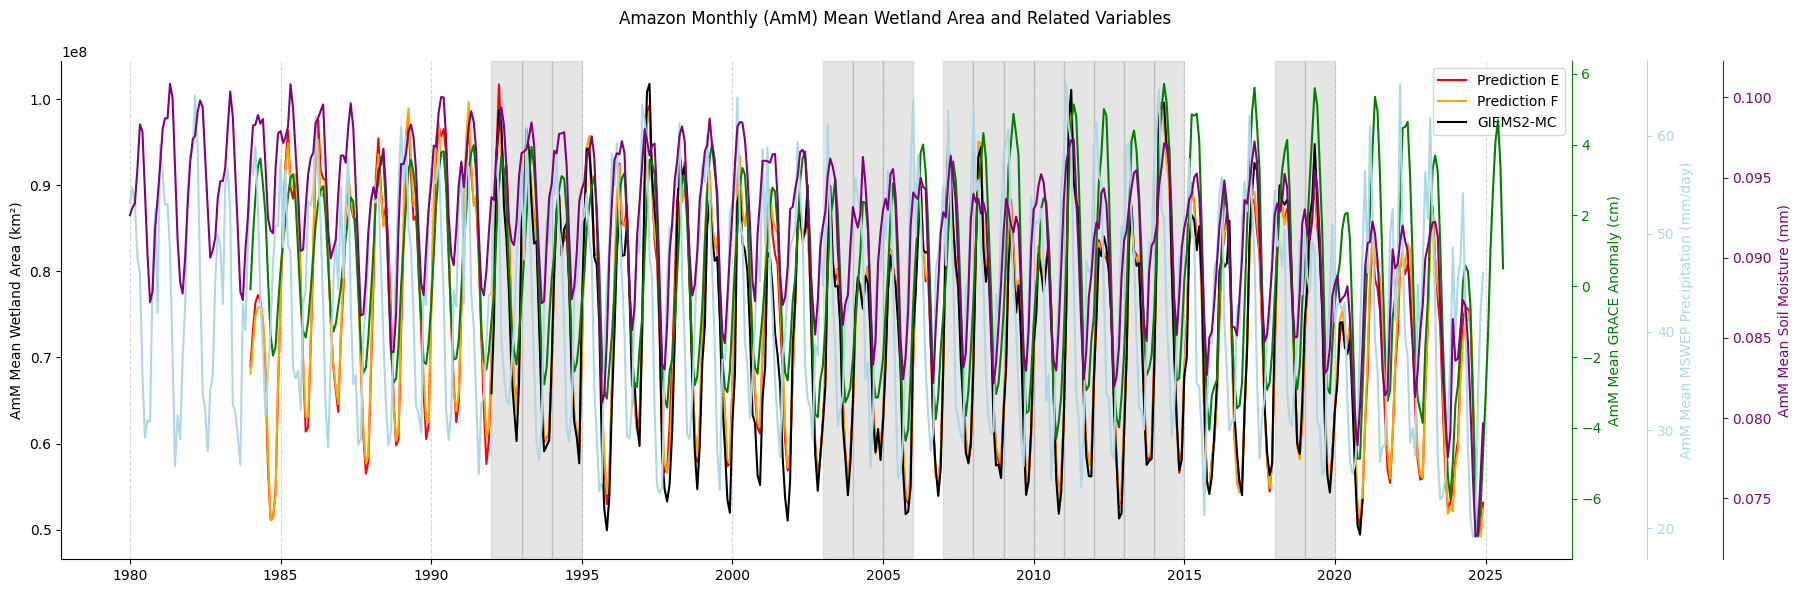

In [46]:
gen_region_reduce(
    lat_slice=slice(-30, 20),
    lon_slice=slice(-80, -40),
    time_reso="MS",
    short_name="AmM",
    long_name="Amazon Monthly",
)

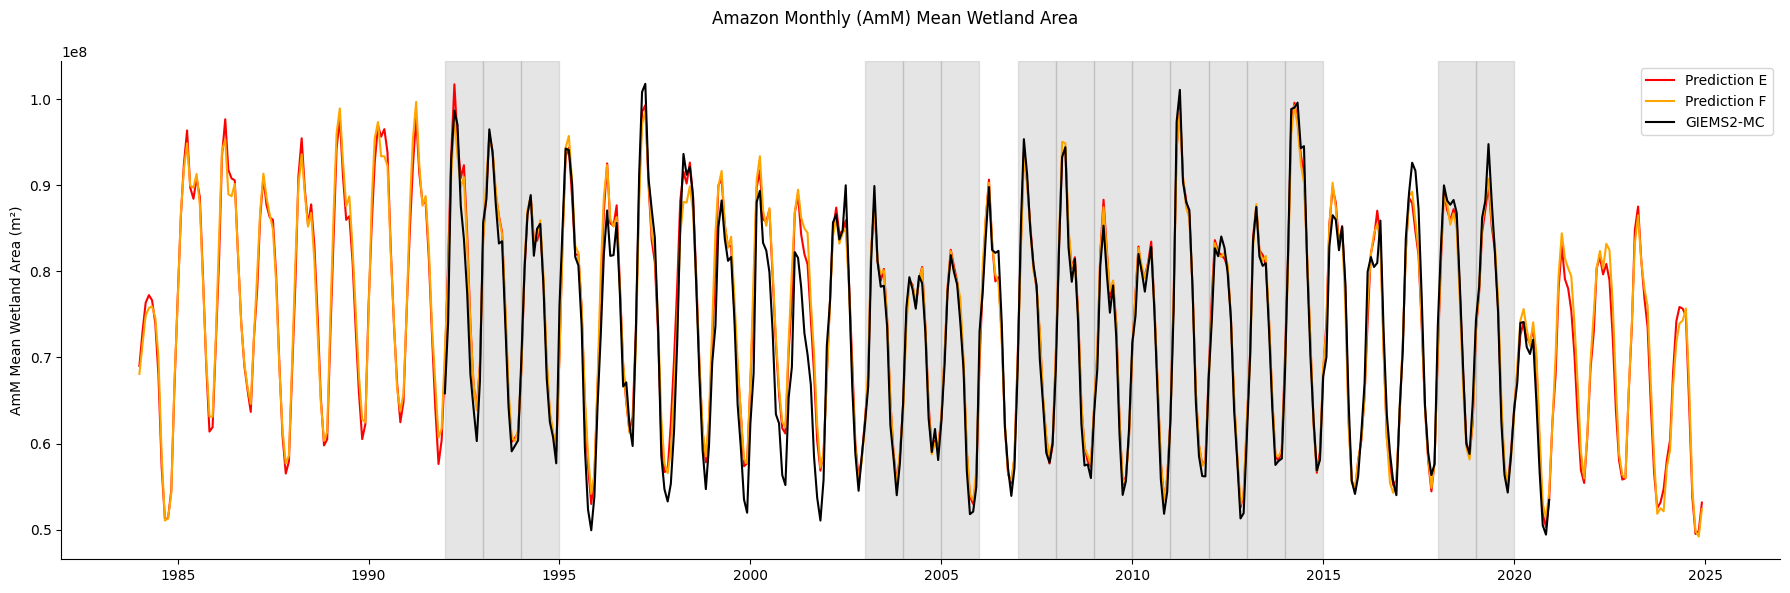

In [196]:
gen_region_awet(
    lat_slice=slice(-30, 20),
    lon_slice=slice(-80, -40),
    time_reso="MS",
    short_name="AmM",
    long_name="Amazon Monthly",
)

Africa Yearly

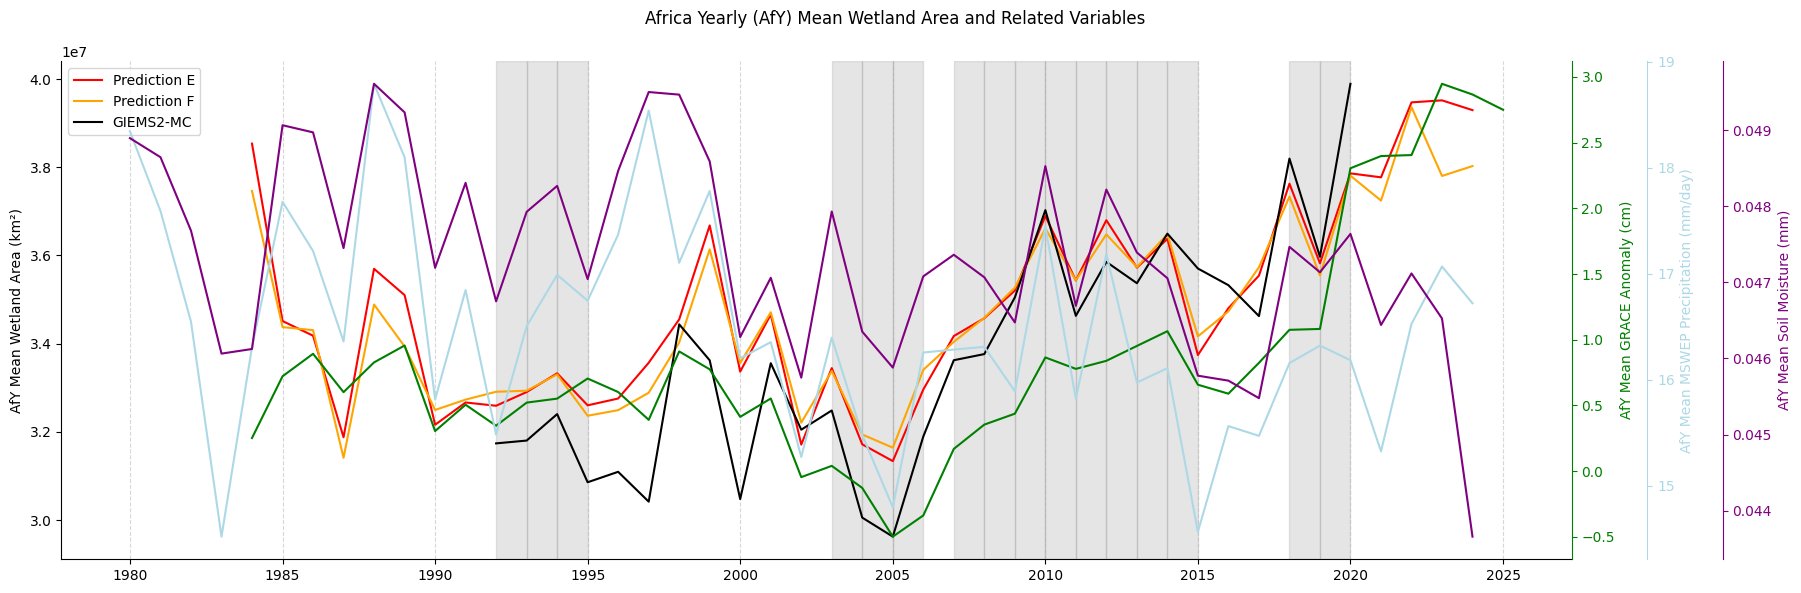

In [47]:
gen_region_reduce(
    lat_slice=slice(-40, 40),
    lon_slice=slice(-20, 40),
    time_reso="YS",
    short_name="AfY",
    long_name="Africa Yearly",
)

Africa Monthly

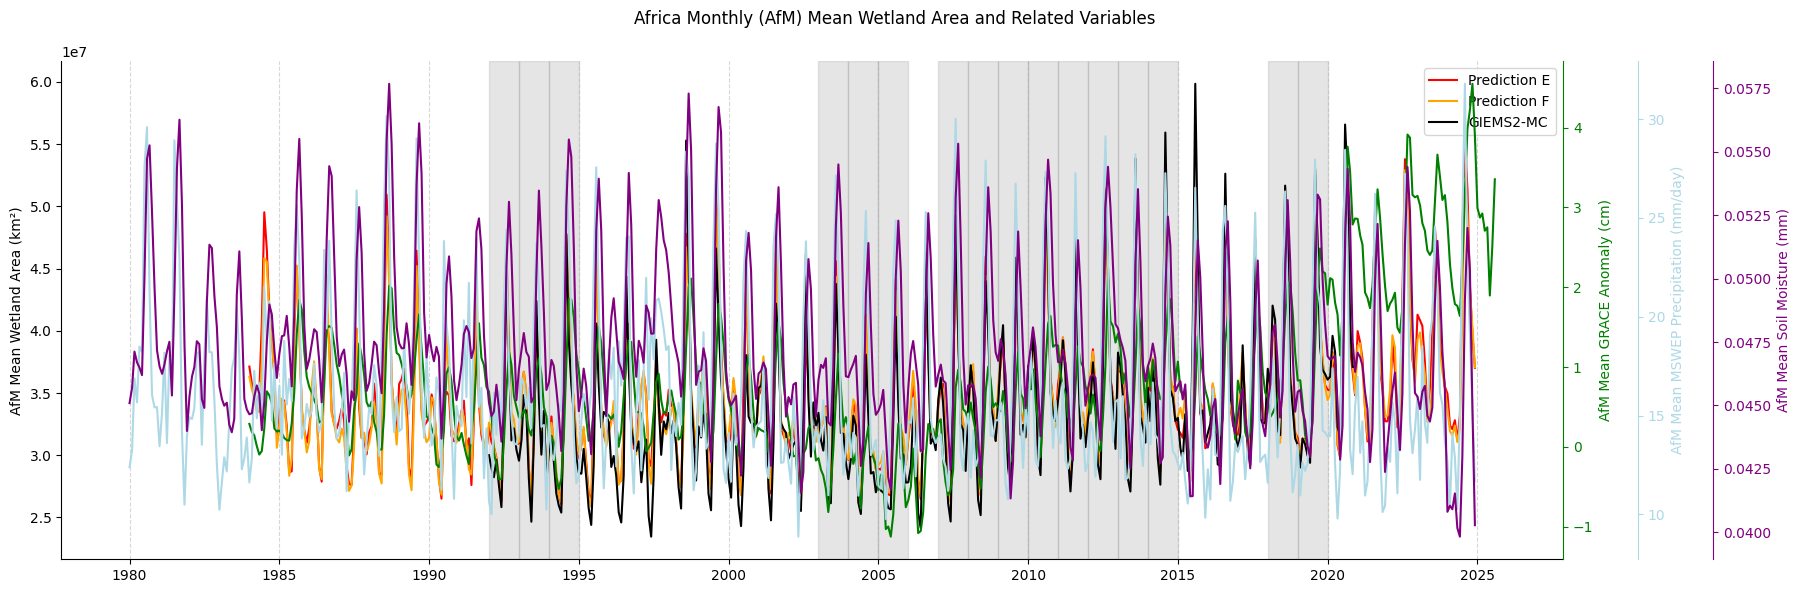

In [48]:
gen_region_reduce(
    lat_slice=slice(-40, 40),
    lon_slice=slice(-20, 40),
    time_reso="MS",
    short_name="AfM",
    long_name="Africa Monthly",
)

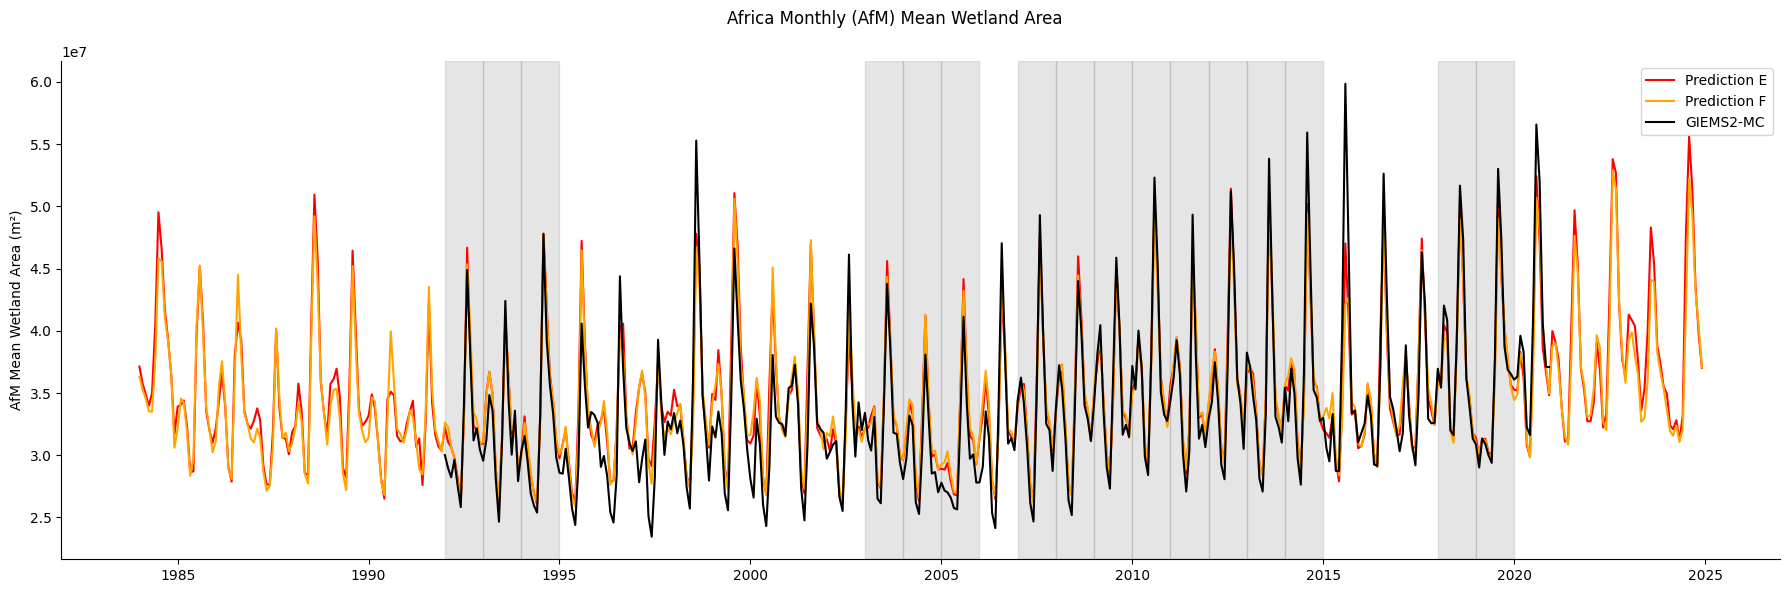

In [197]:
gen_region_awet(
    lat_slice=slice(-40, 40),
    lon_slice=slice(-20, 40),
    time_reso="MS",
    short_name="AfM",
    long_name="Africa Monthly",
)

Southeast Asia Yearly

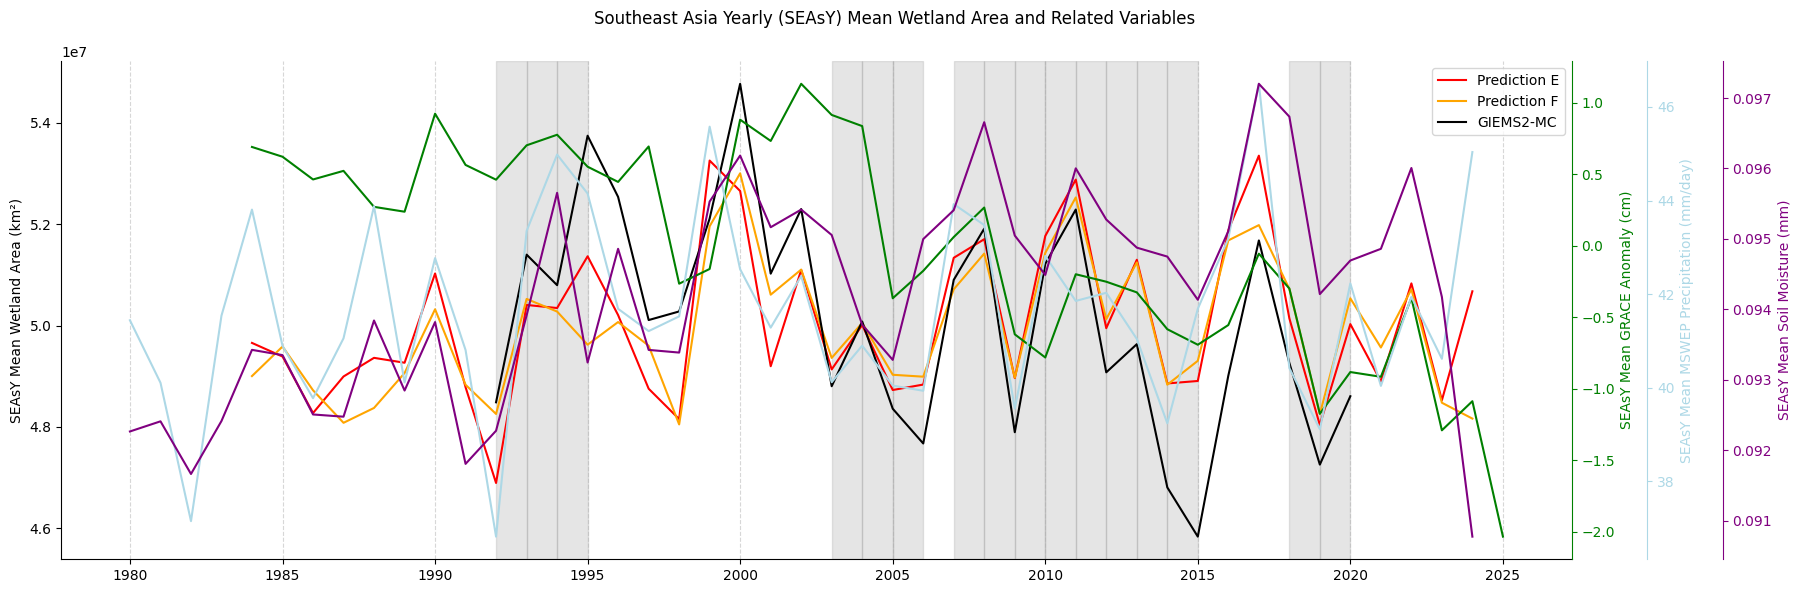

In [187]:
gen_region_reduce(
    lat_slice=slice(0, 30),
    lon_slice=slice(85, 120),
    time_reso="YS",
    short_name="SEAsY",
    long_name="Southeast Asia Yearly",
)

Southest Asia Monthly

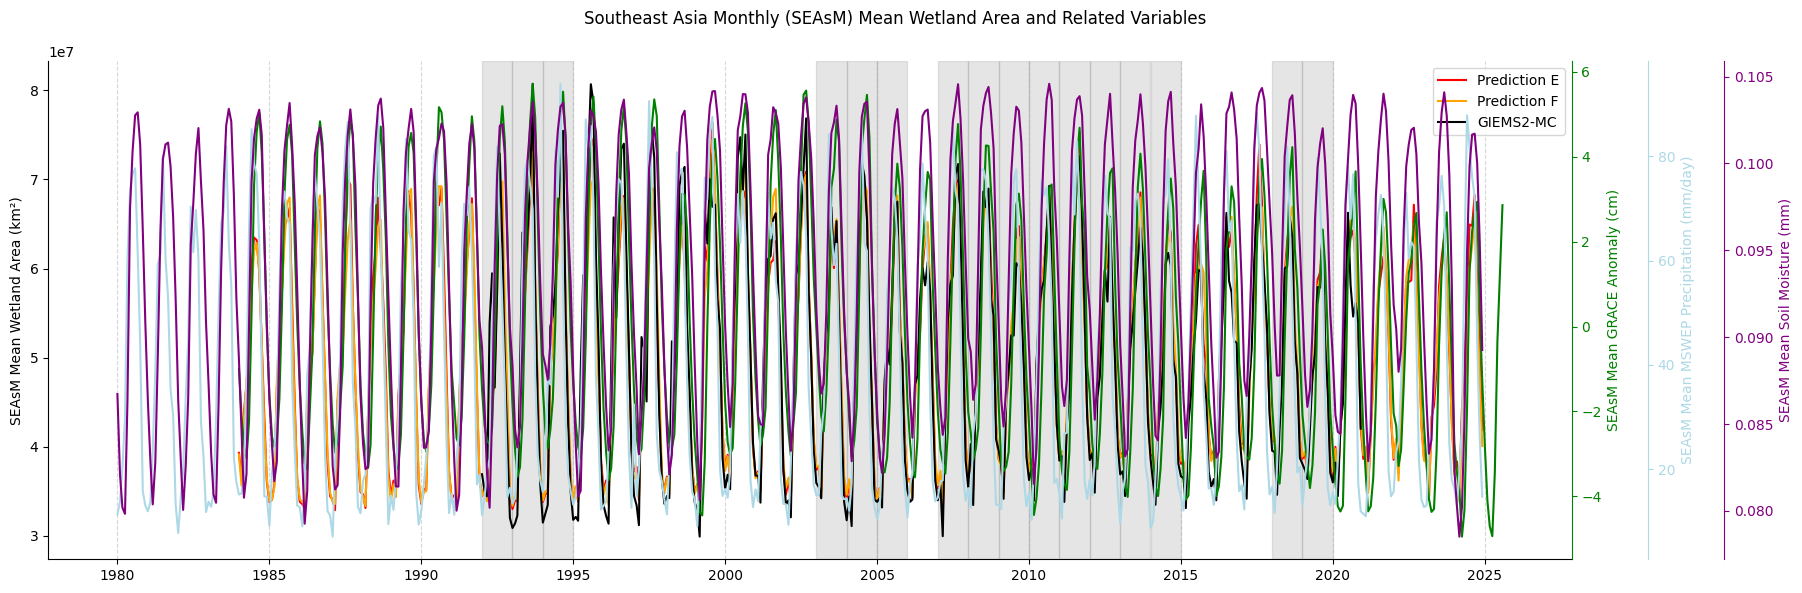

In [188]:
gen_region_reduce(
    lat_slice=slice(0, 30),
    lon_slice=slice(85, 120),
    time_reso="MS",
    short_name="SEAsM",
    long_name="Southeast Asia Monthly",
)

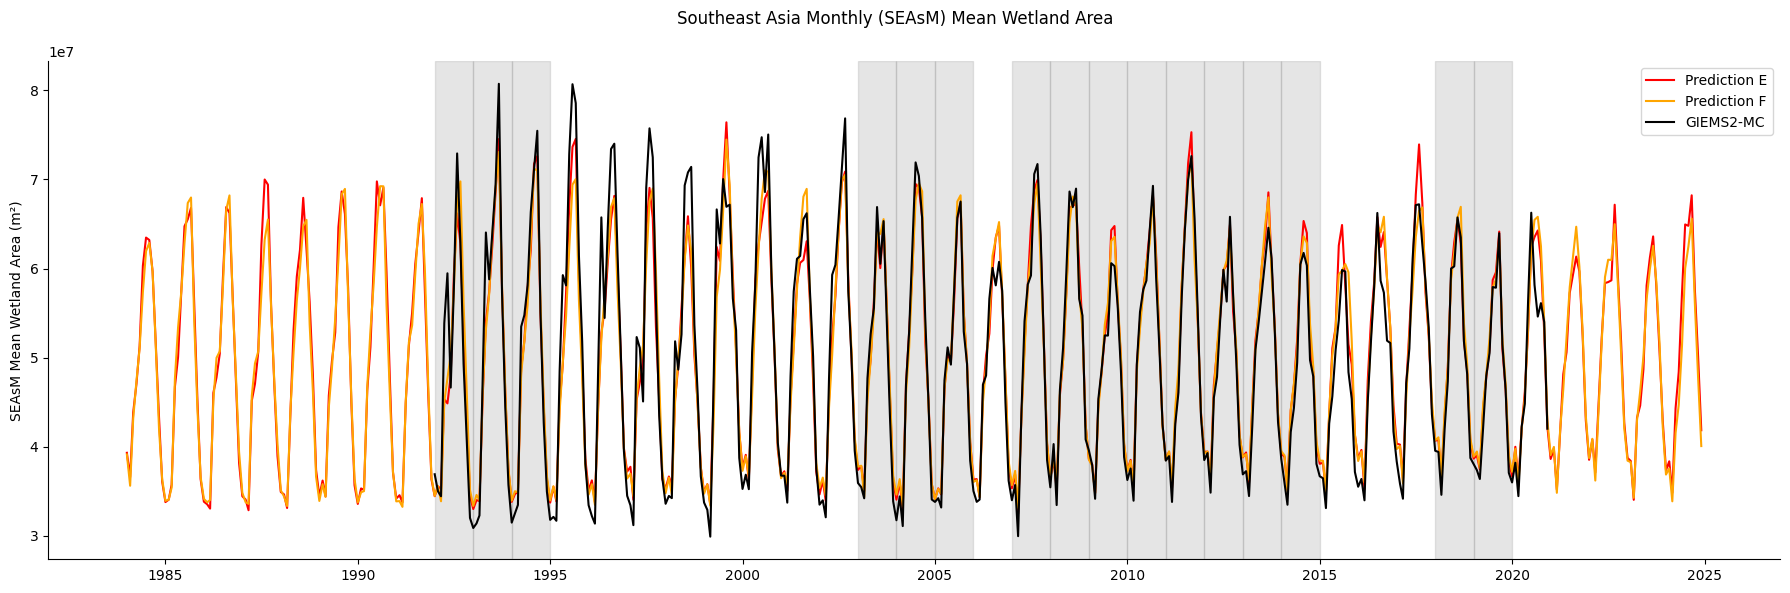

In [198]:
gen_region_awet(
    lat_slice=slice(0, 30),
    lon_slice=slice(85, 120),
    time_reso="MS",
    short_name="SEAsM",
    long_name="Southeast Asia Monthly",
)

## Map

In [152]:
import warnings

warnings.filterwarnings("ignore")

Define helpers

In [145]:
V_min, V_max = 1e7, 1e8
CMAP = "RdYlGn"


def draw_map(lat_slice, lon_slice, time_slice, short_name, long_name):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle(f"{long_name} Mean Wetland Area Map ({short_name})")
    plt.subplots_adjust(wspace=-0.08)

    GIEAMS_MEAN = (
        giems_area.sel(lat=lat_slice, lon=lon_slice)
        .sel(time=time_slice)
        .mean(dim="time")
    )
    E_MEANS = (
        E_area.sel(lat=lat_slice, lon=lon_slice).sel(time=time_slice).mean(dim="time")
    )
    F_MEANS = (
        F_area.sel(lat=lat_slice, lon=lon_slice).sel(time=time_slice).mean(dim="time")
    )
    HIDE_CBAR = {"shrink": 0, "pad": 0.001, "ticks": [], "label": " "}
    GIEAMS_MEAN.plot(
        ax=axes[0], cmap=CMAP, vmin=V_min, vmax=V_max, cbar_kwargs=HIDE_CBAR
    )
    E_MEANS.plot(ax=axes[1], cmap=CMAP, vmin=V_min, vmax=V_max, cbar_kwargs=HIDE_CBAR)
    F_MEANS.plot(
        ax=axes[2],
        cmap=CMAP,
        vmin=V_min,
        vmax=V_max,
        cbar_kwargs={"label": f"{short_name} Mean Wetland Area (m²)"},
    )

    axes[0].set(
        title="GIEMS2-MC",
        ylabel="Latitude",
        xlabel="",
        yticklabels=[f"{yt:.0f}°" for yt in axes[0].get_yticks()],
        xticklabels=[f"{xt:.0f}°" for xt in axes[0].get_xticks()],
    )
    axes[1].set(
        title="Prediction E",
        ylabel="",
        xlabel="Longitude",
        yticklabels=[],
        xticklabels=[f"{xt:.0f}°" for xt in axes[1].get_xticks()],
    )
    axes[2].set(
        title="Prediction F",
        ylabel="",
        xlabel="",
        yticklabels=[],
        xticklabels=[f"{xt:.0f}°" for xt in axes[2].get_xticks()],
    )
    for ax in axes:
        ax.yaxis.set_tick_params(length=0)
        ax.xaxis.set_tick_params(length=0)
        ax.grid(True, linestyle="--", alpha=0.5)

    fig.savefig(f"figs/{short_name}_map.png", dpi=600)

Amazon

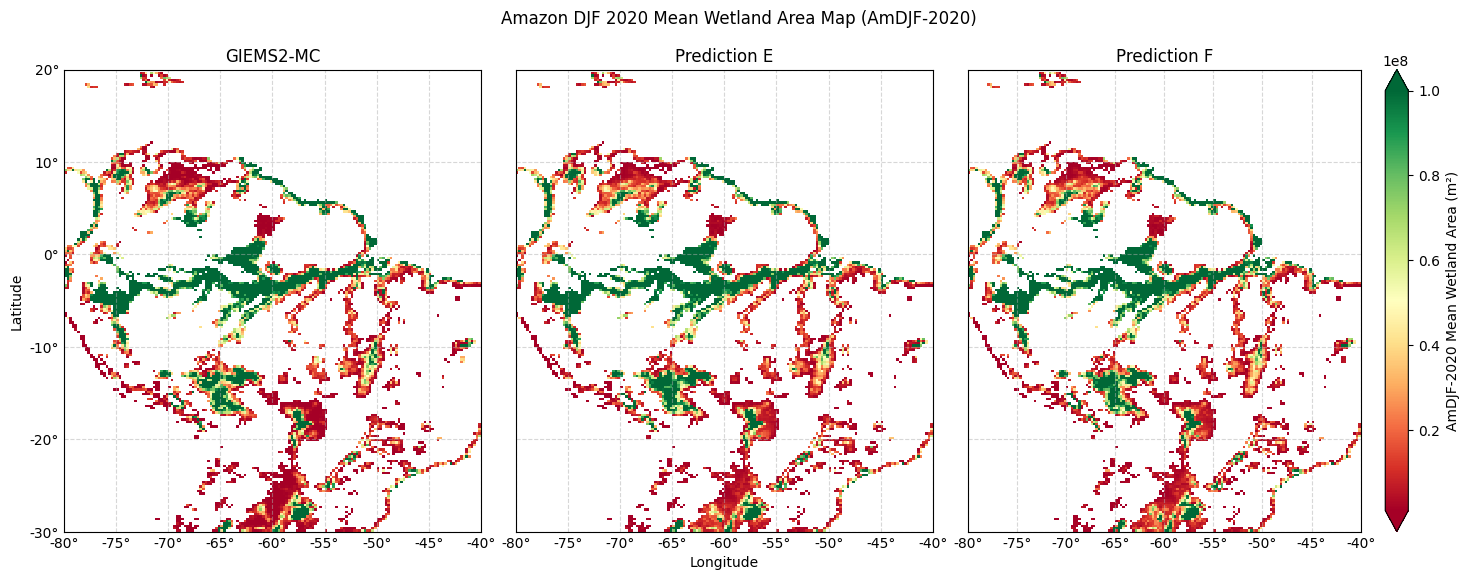

In [163]:
V_min, V_max = 1e6, 1e8

draw_map(
    lat_slice=slice(-30, 20),
    lon_slice=slice(-80, -40),
    time_slice=slice("2019-12-01", "2020-02-29"),
    short_name="AmDJF-2020",
    long_name="Amazon DJF 2020",
)

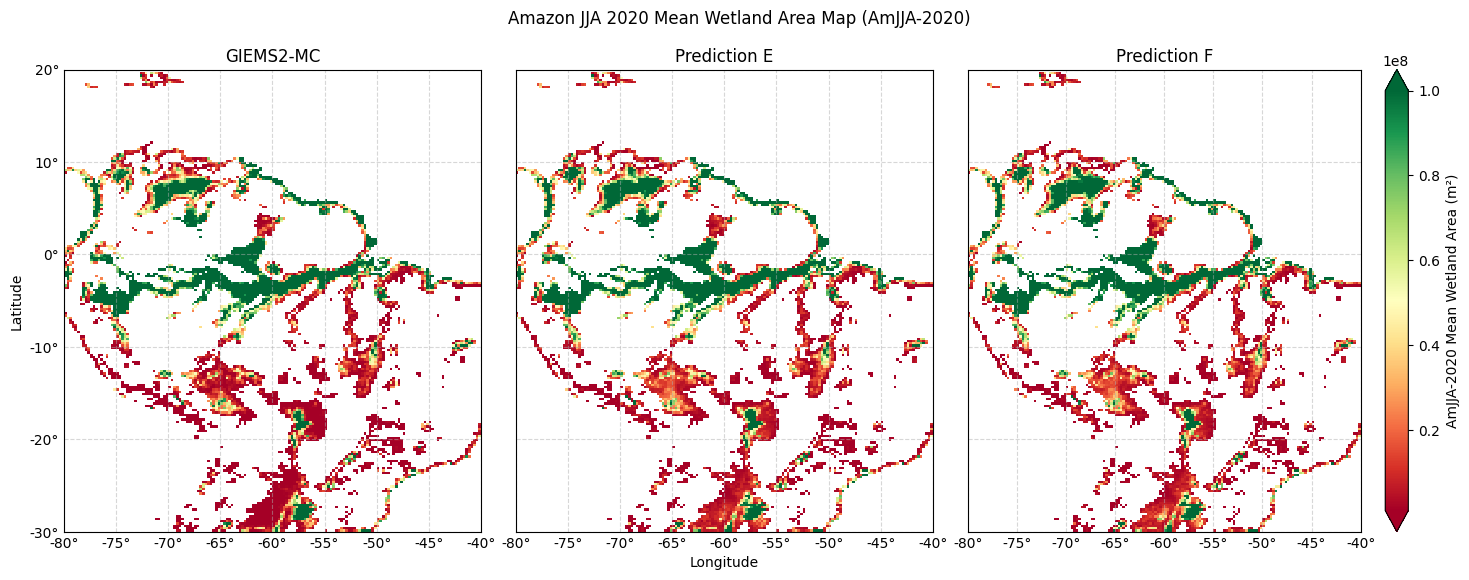

In [164]:
draw_map(
    lat_slice=slice(-30, 20),
    lon_slice=slice(-80, -40),
    time_slice=slice("2020-06-01", "2020-08-31"),
    short_name="AmJJA-2020",
    long_name="Amazon JJA 2020",
)

Africa

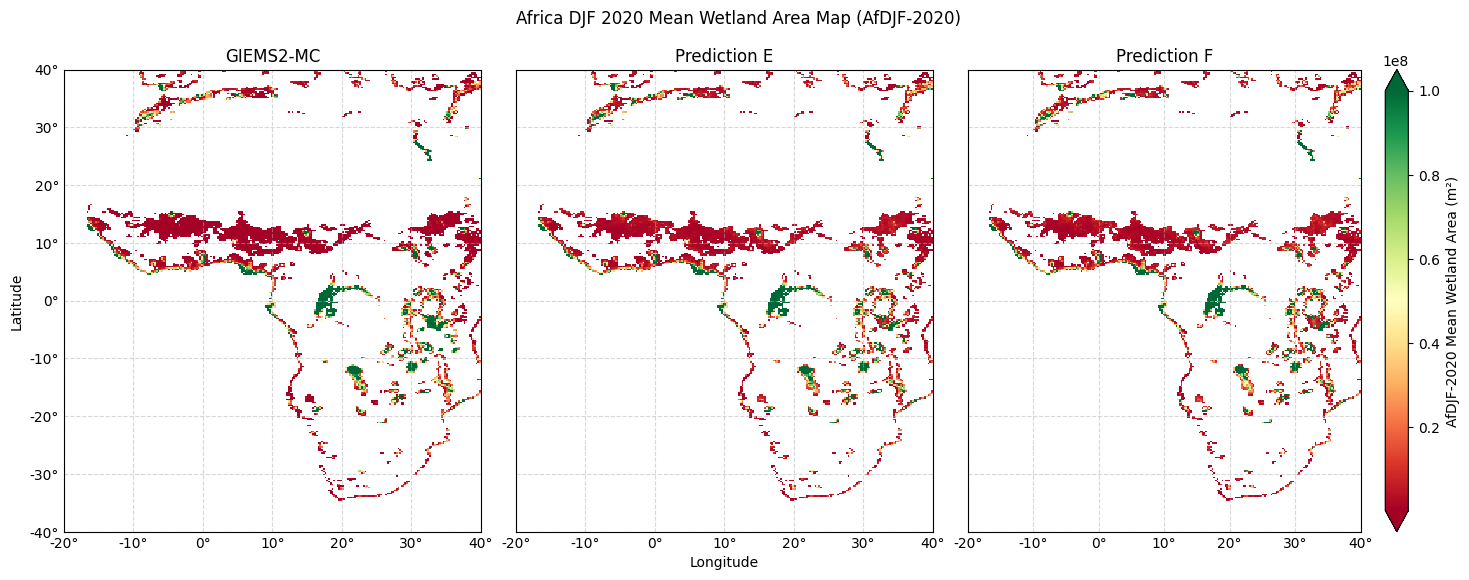

In [173]:
V_min, V_max = 1e5, 1e8
draw_map(
    lat_slice=slice(-40, 40),
    lon_slice=slice(-20, 40),
    time_slice=slice("2019-12-01", "2020-02-29"),
    short_name="AfDJF-2020",
    long_name="Africa DJF 2020",
)

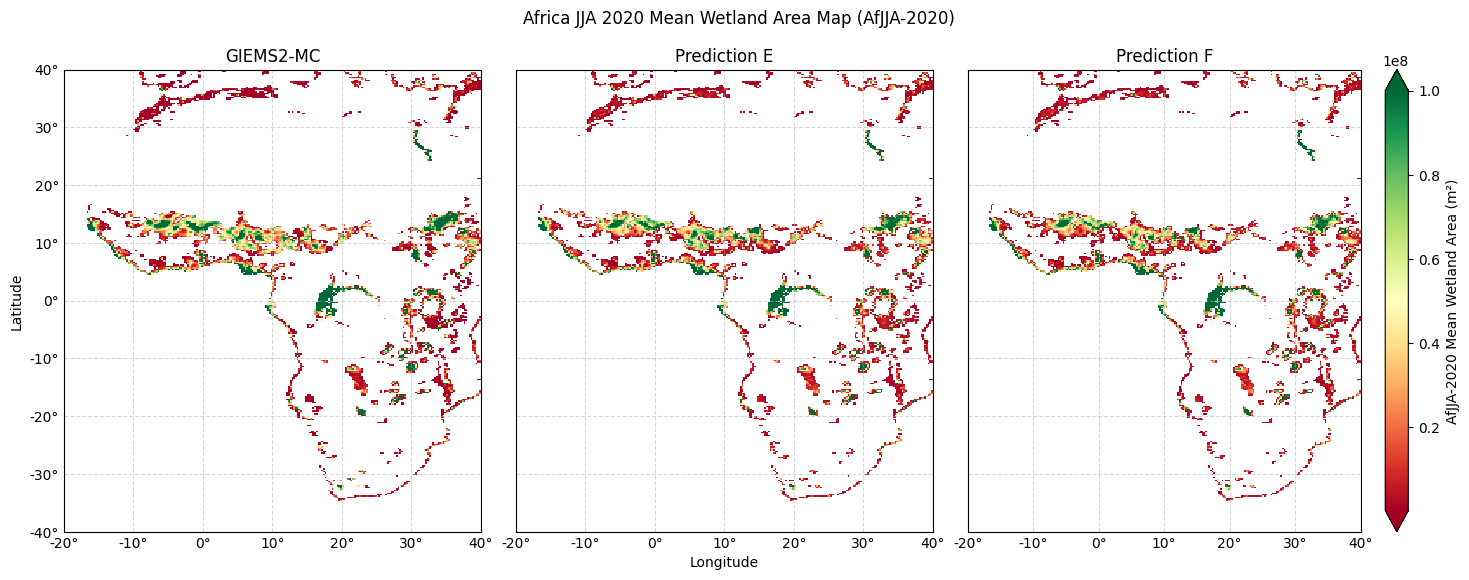

In [174]:
draw_map(
    lat_slice=slice(-40, 40),
    lon_slice=slice(-20, 40),
    time_slice=slice("2020-06-01", "2020-08-31"),
    short_name="AfJJA-2020",
    long_name="Africa JJA 2020",
)

Southeast Asia

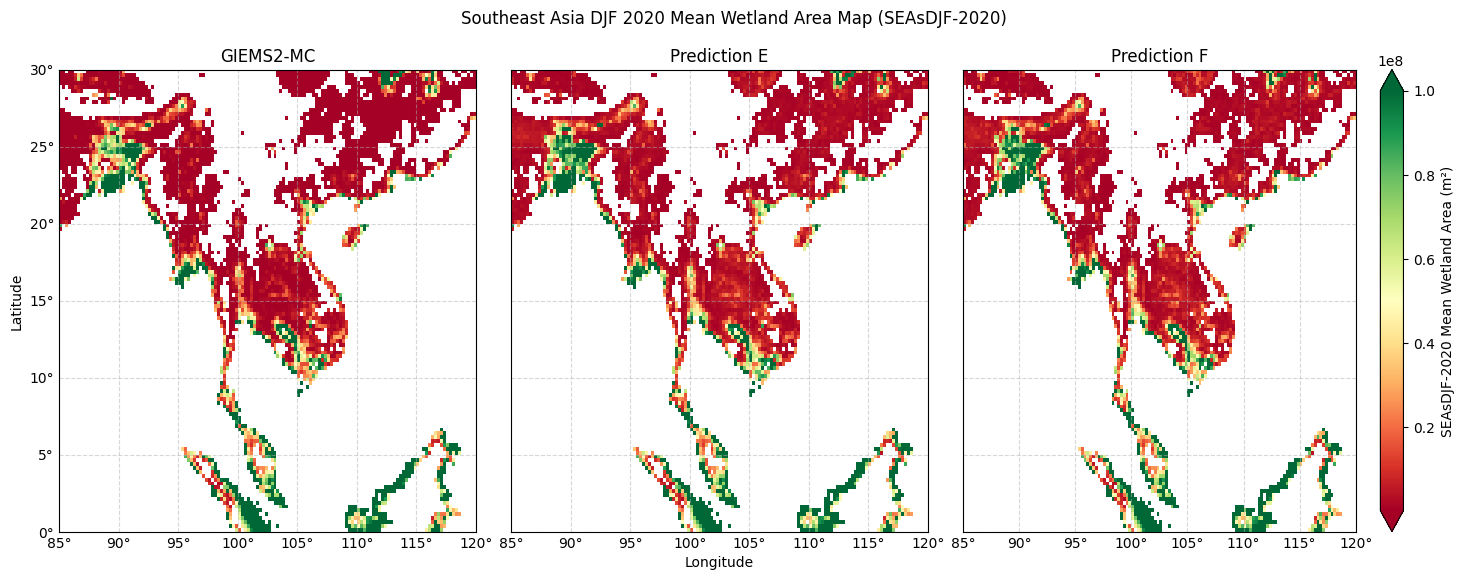

In [185]:
V_min, V_max = 1e5, 1e8
draw_map(
    lat_slice=slice(0, 30),
    lon_slice=slice(85, 120),
    time_slice=slice("2019-12-01", "2020-02-29"),
    short_name="SEAsDJF-2020",
    long_name="Southeast Asia DJF 2020",
)

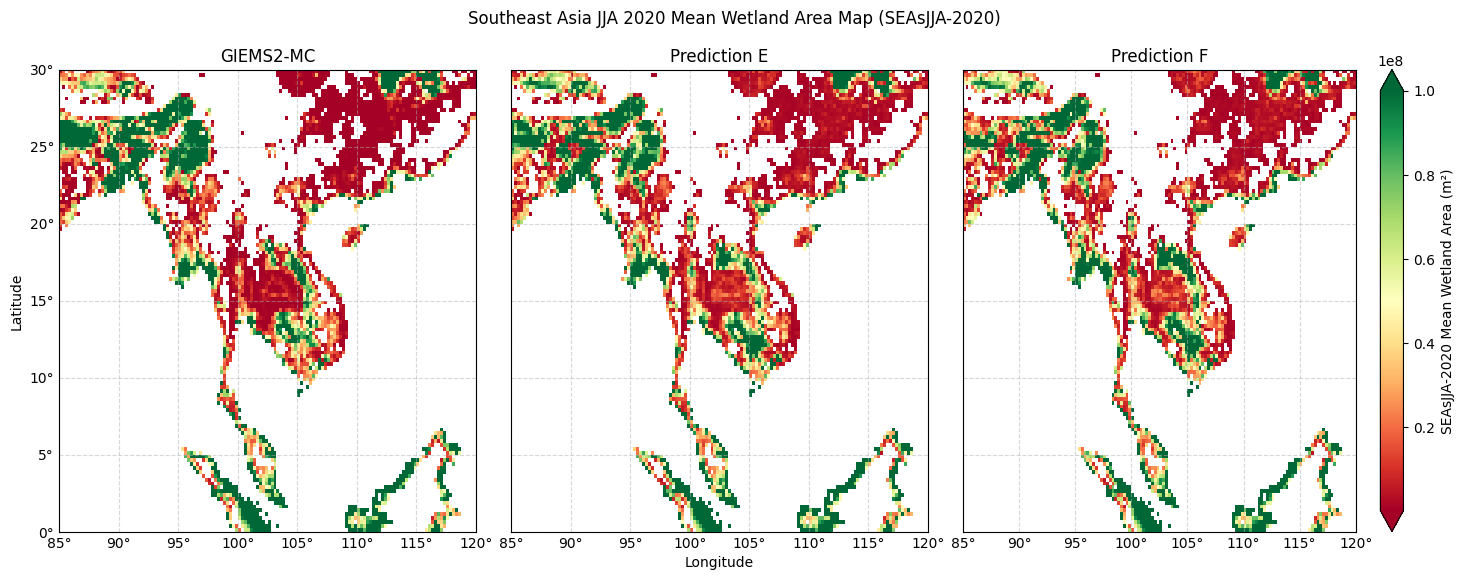

In [186]:
draw_map(
    lat_slice=slice(0, 30),
    lon_slice=slice(85, 120),
    time_slice=slice("2020-06-01", "2020-08-31"),
    short_name="SEAsJJA-2020",
    long_name="Southeast Asia JJA 2020",
)